In [4]:
pip install -q swifter torchvision opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pathlib 
import os
# Importing matplotlib for plotting
import matplotlib.pyplot as plt 
#set style
plt.style.use('ggplot')

# Importing numpy for numerical operations
import numpy as np 

# Importing pandas for preprocessing
import pandas as pd 

# Importing joblib to dump and load embeddings df
import joblib


# Importing cv2 to read images
import cv2

# Importing cosine_similarity to find similarity between images
from sklearn.metrics.pairwise import cosine_similarity

# Importing flatten from pandas to flatten 2-D array
from pandas.core.common import flatten

# Importing the below libraries for our model building

#import torch
import torch
import torch.nn as nn

#import cv models
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

#import image
from PIL import Image

import warnings
warnings.filterwarnings("ignore")


In [6]:
# DISPLAY_DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/"
DATASET_PATH = "Dataset/"
print(os.listdir(DATASET_PATH))

['images', 'myntradataset', 'styles.csv']


In [7]:
# Using error_bad_lines and warn_bad_lines parameters to avoid reading bad lines in this dataset
df = pd.read_csv(DATASET_PATH + 'styles.csv',error_bad_lines=False,warn_bad_lines=False)

#top 10 rows
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [8]:
%%time
import os

def get_all_filenames(directory):
    """
    Returns a set of all filenames in the given directory.
    """
    filenames = {entry.name for entry in os.scandir(directory) if entry.is_file()}
    return filenames

images = get_all_filenames(DATASET_PATH + "images/")

CPU times: total: 15.6 ms
Wall time: 225 ms


In [9]:
def check_image_exists(image_filename):
    """
    Checks if the desired filename exists within the filenames found in the given directory.
    Returns True if the filename exists, False otherwise.
    """
    global images
    if image_filename in images:
        return image_filename
    else:
        return np.nan

df['image'] = df["id"].apply(lambda image: check_image_exists(str(image) + ".jpg"))
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [10]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
#image path 
def image_location(img):
    return 'Dataset/images/'  + img

# function to load image
def import_img(image):
    image = cv2.imread(image_location(image))
    return image

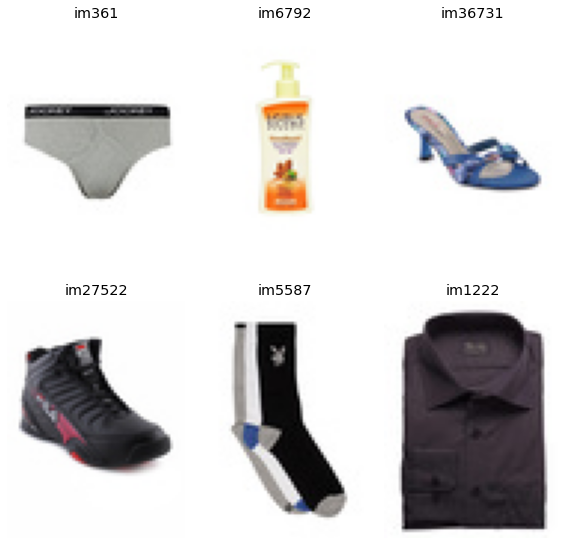

In [11]:
# generation of a dictionary of (title, images)
# print(df)
figures = {'im'+str(i): import_img(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
# print(figures)
plot_figures(figures,2,3)

<AxesSubplot:>

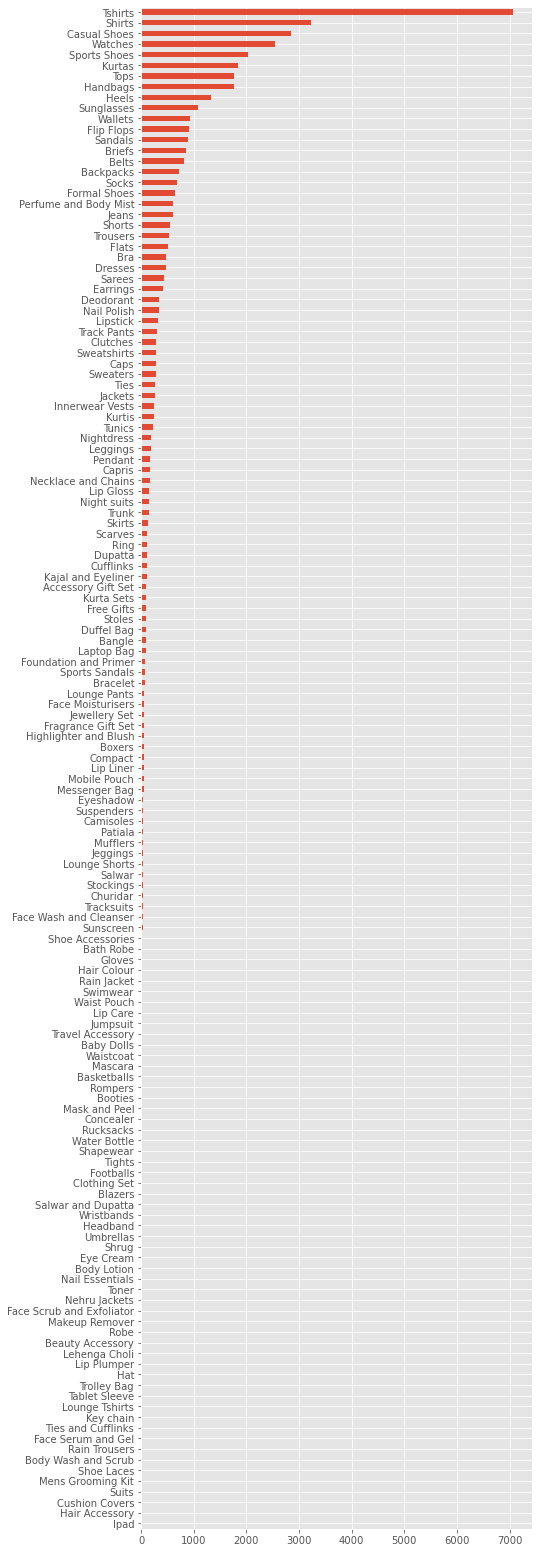

In [12]:
# Understanding the data, how many different articleType are present and knowing their frequency
plt.figure(figsize=(7,28))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [13]:
#ResNet18 PyTorch model to convert

# We will use resent architecture for our work as the name suggest it has 18 layers altogether ith layers of convolution in it
# It has been trained on million of images that are extracted from imagenet dataset it has capacity to classify over 1000 class objects
# Defining the input shape

width= 224
height= 224

# Loading the pretrained model
resnetmodel = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = resnetmodel._modules.get('avgpool')

In [14]:
#evaluate the model
resnetmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# scaling the data
s_data = transforms.Resize((224, 224))

#normalizing
standardize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# converting to tensor
convert_tensor = transforms.ToTensor()

In [16]:
#missing image object
missing_img = []
#function to get embeddings

def vector_extraction(resnetmodel, image_id):
    
    # Using concept of exception handling to ignore missing images
    try: 
        # 1. Load the image with Pillow library
        img = Image.open(image_location(image_id)).convert('RGB')
        
        # 2. Create a PyTorch Variable with the transformed image
        t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
        
        # 3. Create a vector of zeros that will hold our feature vector
        # The 'avgpool' layer has an output size of 512
        embeddings = torch.zeros(512)
        
        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            embeddings.copy_(o.data.reshape(o.data.size(1)))
            
        # 5. Attach that function to our selected layer
        hlayer = layer.register_forward_hook(copy_data)
        
        # 6. Run the model on our transformed image
        resnetmodel(t_img)
        
        # 7. Detach our copy function from the layer
        hlayer.remove()
        emb = embeddings
        
        # 8. Return the feature vector
        return embeddings
    
    # If file not found
    except FileNotFoundError:
        # Store the index of such entries in missing_img list and drop them later
        missed_img = df[df['image']==image_id].index
        print(missed_img)
        missing_img.append(missed_img)

In [17]:
# Testing if our vector_extraction function works well on sample image
sample_embedding_0 = vector_extraction(resnetmodel, df.iloc[0].image)

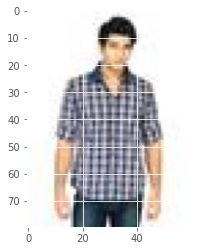

In [18]:
# Plotting the sample image and its embeddings
img_array = import_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# # print(img_array.shape)
# print(sample_embedding_0)

In [19]:
df.shape

(44424, 11)

In [20]:
%%time
import swifter
 
# Applying embeddings on subset of this huge dataset
df_embeddings = df[:5000] #We can apply on entire df, like: df_embeddings = df

#looping through images to get embeddings
map_embeddings = df_embeddings['image'].swifter.apply(lambda img: vector_extraction(resnetmodel, img))

#convert to series
df_embs        = map_embeddings.apply(pd.Series)
print(df_embs.shape)
df_embs.head()


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 512)
CPU times: total: 20min 2s
Wall time: 5min 7s


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.016732,0.983267,0.040268,0.113140,0.205126,1.246754,0.035904,0.336803,1.327888,0.480528,...,0.584026,0.483292,1.229779,0.738920,0.000000,0.035314,1.740416,0.887333,0.004988,0.036427
1,0.034120,0.804466,0.071094,0.286108,0.118644,0.485673,0.767112,0.116924,1.131223,1.229430,...,0.125502,0.554489,0.160279,0.211642,0.000000,0.921632,1.210377,0.750111,0.015514,0.182357
2,0.306780,0.196792,2.325820,0.337870,0.206403,0.410262,2.865740,0.493548,2.894565,3.824198,...,0.377006,3.216579,2.293664,1.343938,1.047548,0.016881,2.759720,0.630300,0.114623,0.002224
3,0.052566,0.312827,0.318464,0.045759,0.207993,0.486138,0.871357,0.437959,0.861974,1.257671,...,0.000401,0.126219,0.117900,0.174460,0.000000,0.004943,1.039022,0.150582,0.009435,0.015908
4,0.146032,0.624985,0.023858,0.201499,0.273301,2.073839,0.038832,0.537267,1.338016,0.428539,...,0.039452,1.069758,0.774632,0.874318,0.000000,0.010583,2.638507,0.303630,0.005840,0.026666


In [21]:
#export the embeddings 
df_embs.to_csv('df_embs.csv')

# importing the embeddings  
df_embs = pd.read_csv('df_embs.csv')
df_embs.drop(['Unnamed: 0'],axis=1,inplace=True)
df_embs.dropna(inplace=True)

In [22]:
#exporting as pkl
joblib.dump(df_embs, 'df_embs.pkl', 9)

#importing the pkl
df_embs = joblib.load('df_embs.pkl')

In [23]:
# Calculating similarity between images ( using embedding values )
cosine_sim = cosine_similarity(df_embs) 

# Previewing first 4 rows and 4 columns similarity just to check the structure of cosine_sim
cosine_sim[:4, :4]

array([[1.        , 0.76683546, 0.54555201, 0.77950725],
       [0.76683546, 1.        , 0.4961708 , 0.8849266 ],
       [0.54555201, 0.4961708 , 1.        , 0.52310662],
       [0.77950725, 0.8849266 , 0.52310662, 1.        ]])

In [24]:
# Storing the index values in a series index_vales for recommending
index_vales = pd.Series(range(len(df)), index=df.index)
index_vales

# Defining a function that gives recommendations based on the cosine similarity score
def recomend_images(ImId, df, top_n = 6):
    
    # Assigning index of reference into sim_ImId
    sim_ImId    = index_vales[ImId]
    
    # Storing cosine similarity of all other items with item requested by user in sim_scores as a list
    sim_scores = list(enumerate(cosine_sim[sim_ImId]))
    
    # Sorting the list of sim_scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Extracting the top n values from sim_scores
    sim_scores = sim_scores[1:top_n+1]
    
    # ImId_rec will return the index of similar items
    ImId_rec    = [i[0] for i in sim_scores]
    
    # ImId_sim will return the value of similarity score
    ImId_sim    = [i[1] for i in sim_scores]
    
    return index_vales.iloc[ImId_rec].index, ImId_sim

# Sample given below
recomend_images(3810, df, top_n = 5)


(Int64Index([2400, 3899, 3678, 4818, 2354], dtype='int64'),
 [0.9632298639373618,
  0.9571409769082698,
  0.9557428253080555,
  0.9539640555114928,
  0.9537699504642752])

In [25]:
def Rec_viz_image(input_imageid): 

    # Getting recommendations
    idx_rec, idx_sim = recomend_images(input_imageid, df, top_n = 6)
    
    # Printing the similarity score
    print (idx_sim)
    
    # Plotting the image of item requested by user
    plt.imshow(cv2.cvtColor(import_img(df.iloc[input_imageid].image), cv2.COLOR_BGR2RGB))

    # Generating a dictionary of { index, image }
    figures = {'im'+str(i): import_img(row.image) for i, row in df.loc[idx_rec].iterrows()}
    
    # Plotting the similar images in a figure, with 2 rows and 3 columns
    plot_figures(figures, 2, 3)

[0.9632298639373618, 0.9571409769082698, 0.9557428253080555, 0.9539640555114928, 0.9537699504642752, 0.9536933612435639]


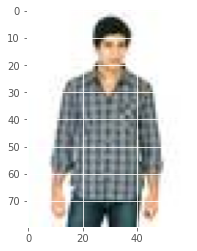

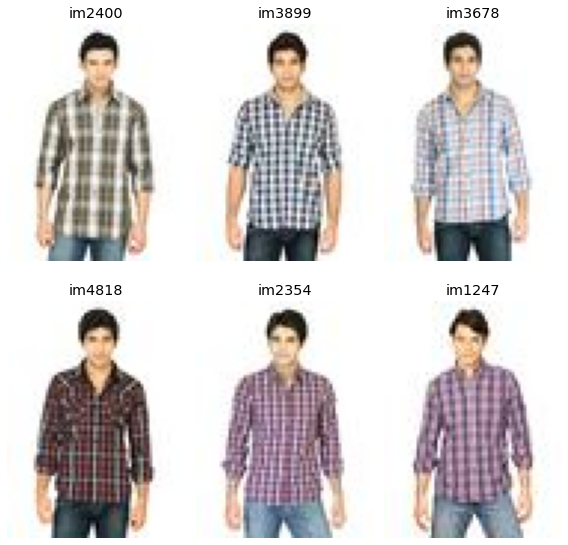

In [26]:
Rec_viz_image(3810)

[0.9726985504510337, 0.9465230763436325, 0.9442472091289329, 0.9418147257779246, 0.9382510708235534, 0.9371736945295107]


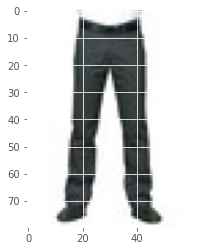

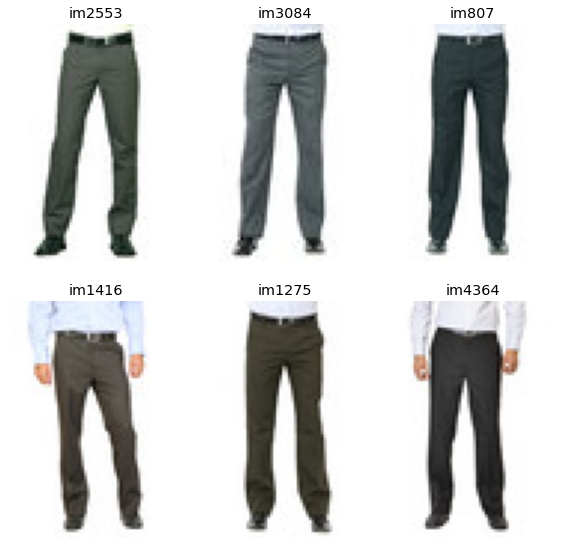

In [27]:
Rec_viz_image(2001)

In [28]:
#function to get embeddings
def recm_user_input(image_id):
    
    # Exception to handle missing images 
    
    img = Image.open('Dataset/images/'+image_id).convert('RGB')
    print(type(img))
        
    t_img = Variable(standardize(convert_tensor(s_data(img))).unsqueeze(0))
       
    embeddings = torch.zeros(512)
        #print('H',embeddings)
    def select_d(m, i, o):
        embeddings.copy_(o.data.reshape(o.data.size(1)))
    hlayer = layer.register_forward_hook(select_d)
    resnetmodel(t_img)
    hlayer.remove()
    emb = embeddings
    
    cs = cosine_similarity(emb.unsqueeze(0),df_embs)
    cs_list = list(flatten(cs))
    cs_df = pd.DataFrame(cs_list,columns=['Score'])
    cs_df = cs_df.sort_values(by=['Score'],ascending=False)
        
# Printing Cosine Similarity
    print(cs_df['Score'][:10])
    # Extracting the index of top 10 similar items/images
    top10 = cs_df[:10].index
    top10 = list(flatten(top10))
    images_list = []
    for i in top10:
        image_id = df[df.index==i]['image']
        print(image_id)
        images_list.append(image_id)
    images_list = list(flatten(images_list))
    print(images_list)
    
    # Plotting the image of item requested by user
    print("Hi",image_id)
    #img_print =Image.open('../input/afsfssgg/'+image_id)
    #print(img_print)
    #plt.imshow(img_print)
# Generating a dictionary { index, image }
    figures = {'im'+str(i): Image.open('Dataset/images/' + i) for i in images_list}
    fig, axes = plt.subplots(2, 5, figsize = (8,8) )
    for index,name in enumerate(figures):
        axes.ravel()[index].imshow(figures[name])
        axes.ravel()[index].set_title(name)
        axes.ravel()[index].set_axis_off()
    plt.tight_layout()

        #return embeddings   
    figures = {'im'+str(i):import_img(row.image) for i, row in df.sample(6).iterrows()}

<class 'PIL.Image.Image'>
158     0.898582
3069    0.887443
3326    0.854198
3092    0.847117
58      0.841599
3211    0.840787
168     0.823277
2489    0.822907
130     0.820571
591     0.818414
Name: Score, dtype: float64
158    56670.jpg
Name: image, dtype: object
3069    23270.jpg
Name: image, dtype: object
3326    17426.jpg
Name: image, dtype: object
3092    11180.jpg
Name: image, dtype: object
58    11188.jpg
Name: image, dtype: object
3211    46419.jpg
Name: image, dtype: object
168    45869.jpg
Name: image, dtype: object
2489    29943.jpg
Name: image, dtype: object
130    8110.jpg
Name: image, dtype: object
591    29910.jpg
Name: image, dtype: object
['56670.jpg', '23270.jpg', '17426.jpg', '11180.jpg', '11188.jpg', '46419.jpg', '45869.jpg', '29943.jpg', '8110.jpg', '29910.jpg']
Hi 591    29910.jpg
Name: image, dtype: object


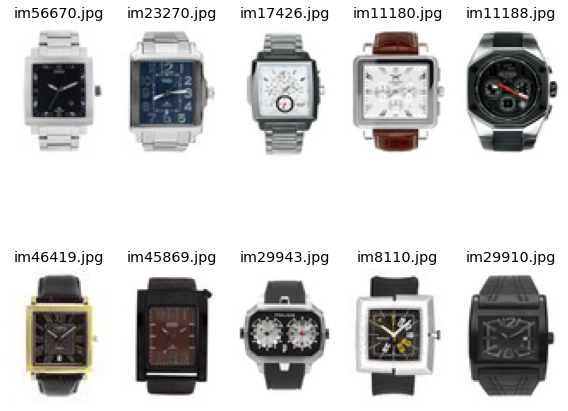

In [29]:
recm_user_input('11178.jpg')

In [30]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [31]:
%%time
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)

CPU times: total: 46.2 s
Wall time: 7.5 s


In [32]:
df1 = df[:5000]

In [33]:
df1['tsne-2d-one'] = tsne_results[:,0]
df1['tsne-2d-two'] = tsne_results[:,1]

In [34]:
pip install umap-learn[plot]

Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

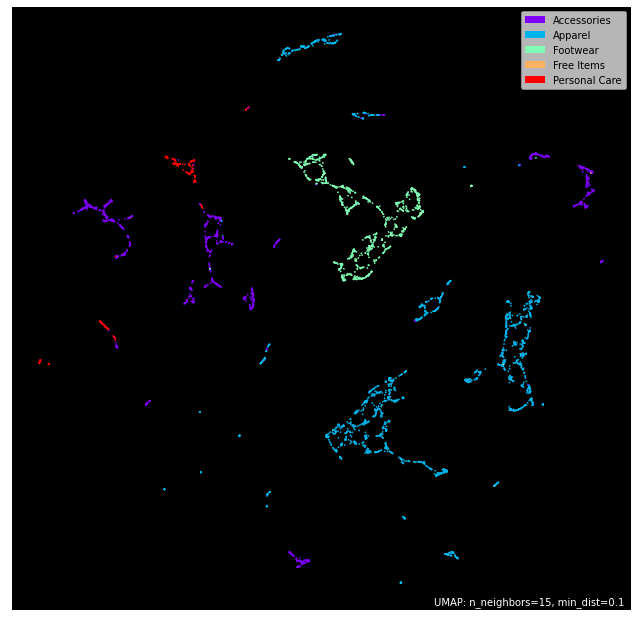

In [35]:
import umap.plot
mapper_org = umap.UMAP().fit(tsne_results)
umap.plot.points(mapper_org, labels=df1["masterCategory"], theme='fire')

In [36]:
pip show ope

Note: you may need to restart the kernel to use updated packages.


In [37]:
cv2.__version__

'4.6.0'